In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import astropy.units as u
import astropy.constants as const
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

In [3]:
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator

color_map = {
    'cyan': '#66c2a5',
    'orange': '#ff7f00',
    'blue': '#8da0cb',
    'purple': '#7570b3',
    'pink': '#fccde5',
    'green': '#33a02c',
    'yellow': '#ffd92f',
    'brown': '#e5c494',
    'magenta': '#f1598a',
    'grey': '0.3'
}

In [4]:
import glob
import os
import sys
sys.path.append('../tools/')

from fits2ascii import wavelength_convert_air_vacuum
from visual import rcparams_format

rcparams_format(mpl.rcParams)

In [5]:
files = sorted(glob.glob("../../Spectra/2023-04-26_LRIS/pypeit/keck_lris_red_mark4_B/Science/spec2d*SN2022joj*fits"))
spec = np.loadtxt("./data/ZTF22aajijjf_20230426_LRIS.ascii")

In [11]:
def plot_box_spec(wave, flux):
    flux_plot = np.repeat(flux, 2)
    wv_plot = wave.copy()
    wv_plot[:-1] += np.diff(wave) / 2
    wv_plot = np.append(
        wave[0] - (wave[1] - wave[0]) / 2,
        np.append(np.repeat(wv_plot[0:-1], 2),
                  wave[-1] + (wave[-1] - wave[-2]) / 2))

    return wv_plot, flux_plot

/Users/chang/Desktop/SN2022joj/spectroscopy/../tools/fits2ascii.py:15: RuntimeWarning: divide by zero encountered in divide
  sigma = 1.0/lambda1*1e8


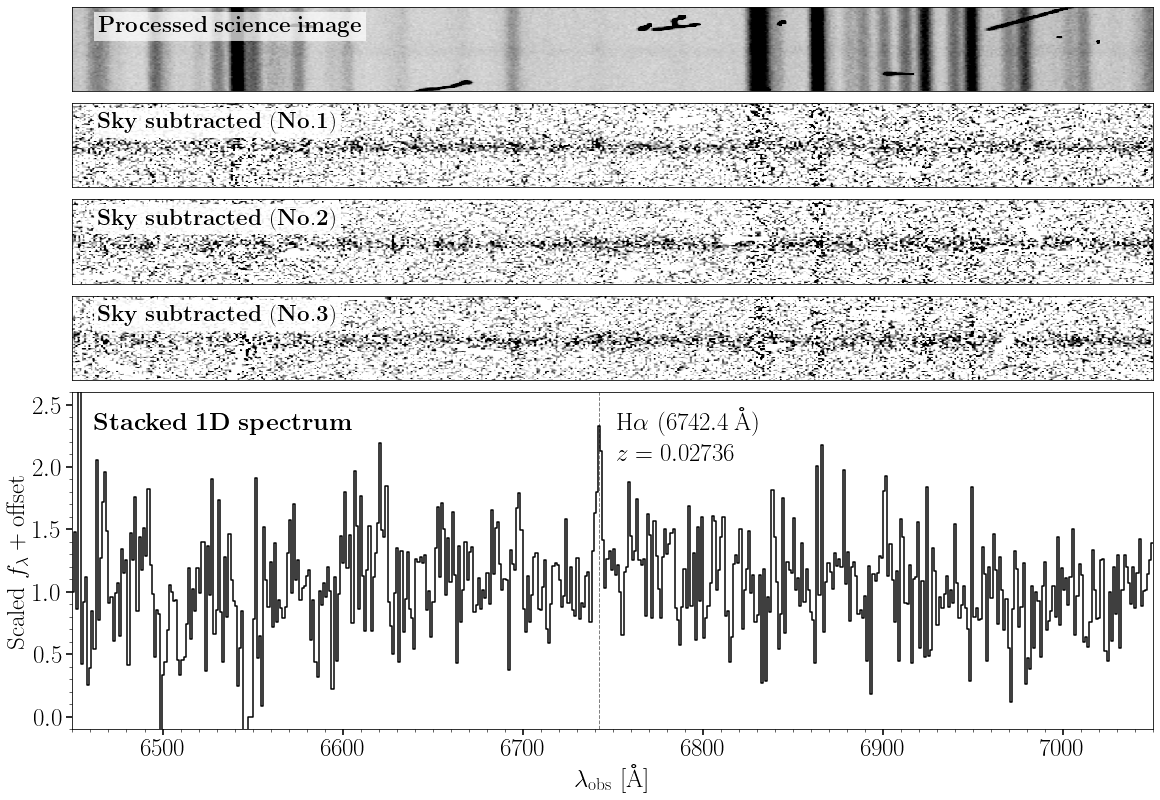

In [30]:
fig, ax = plt.subplots(8, 1, figsize=(16, 11), constrained_layout=True, sharey=True)
left, right = 900, 1400
wv_left, wv_right = 6450, 7050
for k in range(3):
    with fits.open(files[k]) as hdu:
        sciimg = hdu[1].data
        skymodel = hdu[3].data
        bpmmask = hdu[9].data
        waveimg = wavelength_convert_air_vacuum(hdu[8].data)

    ax[k + 1].imshow(
        np.where(bpmmask == 0, sciimg - skymodel, -1).T,
        cmap="Greys",
        vmin=0,
        vmax=25,
        aspect="auto",
    )

    x1 = waveimg[left, 925:930].mean()
    x2 = waveimg[right, 925:930].mean()

    A = (right - left) / (x2 - x1)
    B = right - A * x2
    ax[k + 1].set_xlim(A * np.array([wv_left, wv_right]) + B)
    ax[k + 1].set_xticks([])
    ax[k + 1].text(
        A * wv_left + B + 12,
        942,
        r"$\mathbf{Sky\ subtracted\ (No." + rf"{k + 1}" + r")}$",
        fontsize=22.5,
        bbox={"alpha": 0.9, "color": "w", "lw": 0},
    )
    if k == 0:
        ax[0].imshow(sciimg.T, cmap="Greys", vmin=0, vmax=500, aspect="auto")
        ax[0].set_xlim(A * np.array([wv_left, wv_right]) + B)
        ax[0].set_xticks([])
        ax[0].text(
            A * wv_left + B + 12,
            942,
            r"$\mathbf{Processed\ science\ image}$",
            fontsize=22.5,
            bbox={"alpha": 0.7, "color": "w", "lw": 0},
        )

ax[0].set_yticks([])
ax[0].set_ylim(900, 960)

gs = ax[-4].get_gridspec()
# remove the underlying axes
for ax in ax[-4:]:
    ax.remove()
ax_1dspec = fig.add_subplot(gs[-4:])
wv, fl = plot_box_spec(spec[:, 0], spec[:, 1])
ax_1dspec.plot(wv, fl * 5, color="k")
ax_1dspec.text(wv_left + 12, 2.3, r"$\mathbf{Stacked\ 1D\ spectrum}$")

ax_1dspec.set_xlim(wv_left, wv_right)
ax_1dspec.set_ylim(-0.1, 2.6)

ax_1dspec.xaxis.set_major_locator(MultipleLocator(100))
ax_1dspec.xaxis.set_minor_locator(MultipleLocator(10))
ax_1dspec.yaxis.set_major_locator(MultipleLocator(0.5))
ax_1dspec.yaxis.set_minor_locator(MultipleLocator(0.1))

ax_1dspec.set_ylabel(r"$\mathrm{Scaled}\ f_\lambda + \mathrm{offset}$")
ax_1dspec.set_xlabel(r"$\lambda_\mathrm{obs}\ [\mathrm{\r{A}}]$")

z = 0.02736
ax_1dspec.axvline(6562.8 * (1 + z), color="0.5", lw=1, linestyle="--", zorder=-100)
ax_1dspec.text(
    6562.8 * (1 + z) + 10,
    2.3,
    r"$\mathrm{H}\alpha\ $"
    + r"$({:.1f}\,".format(6562.8 * (1 + z))
    + r"\mathrm{\r{A}})$",
)
ax_1dspec.text(6562.8 * (1 + z) + 10, 2.05, rf"$z={z}$")

plt.savefig("../paper/figures/host_spec.pdf", bbox_inches="tight")